# Improving Accuracy

Our implementation of LIF neurons is good enough for many applications but there are lots of ways in which our implementation is imprecise. Namely:

1. If the refractory period ends in the middle of a step (if `0 < self.refractory_time < t_step`) then we pretend that the refractory time ended at the beginning of the step. In reality, the voltage shouldn't have updated for the part of the step where we were in refractory time.
2. If a neuron fires in the middle of a timestep---between $(t - T_{step})$ and $t$---then we are effectively "rounding" the firing time to the nearest timestep, since we assign `self.refractory_time = self.tau_ref` at the end of the step (whereas some of the refractory time should have passed before the step end).
3. We are using Euler's method as a first-order approximation of `self.v`, which has some error (which is magnified for larger values of $T_{step}$).

We can actually "correct" all of these inaccuracies at little computational cost. In fact, by adding accuracy, we can _reduce_ computational cost by running our simulation in larger time steps. You can look at the optional descriptions below to see how we can rectify all of these:



:::{dropdown} 1. Accurately Setting the Refractory Time
## Accurately Setting the Refractory Time (Optional)

Recall that:

$$v(t + \Delta{}t) \approx v(t)(1 - \frac{\Delta{}t}{\tau_{rc}}) + \frac{\Delta{}t}{\tau_{rc}}I(t)$$

Now, consider the image below, which represents a neuron crossing the threshold voltage ($v_{th}$ in the diagram) at some time between $(t - \Delta{}t)$ and $t$. We will call this time $t_{th}$.

![](/_static/images/lif_precision.png)

As this image shows, our neuron **should** exit the refractory period at time $(t - \Delta{}t + t_{th} + \tau_{ref})$. However, it is currently incorrectly exiting the refractory period at time $(t + \tau_{ref})$. Let's rectify this. First, we need to figure out $t_{th}$.

We know that $v(t - \Delta{}t + t_{th}) = v_{th}$ . Using Euler's above, we get:

$$v(t - \Delta{}t + t_{th}) = v_{th} = (1 - \frac{t_{th}}{\tau_{rc}})v(t-\Delta{}t) + \frac{I(t)t_{th}}{\tau_{rc}}$$

Moving things around, we get:

$$t_{th} = \tau_{rc}\frac{v_{th} - v(t - \Delta{}t)}{I(t) - v(t-\Delta{}t)}$$

It can be a little more convenient to rewrite this using $v(t)$ (the potential now) rather than $v(t - \Delta{}t)$ (the potential in the last timestep). We know that they are related by $v(t) = v(t-\Delta{}t)(1 - \frac{\Delta{}t}{\tau_{rc}}) + \frac{I(t)\Delta{}t}{\tau_{rc}}$. Or converseley, $v(t - \Delta{}t) =\frac{\tau_{rc}v(t) - I(t)\Delta{}t}{\tau_{rc}-\Delta{}t}$. Doing the math, you will find that we can solve for $t_{th}$:

$$t_{th} = \frac{\tau_{rc}(v_{th} - v(t)) + \Delta{}t(I(t) - v_{th})}{I(t) - v(t)}$$

Now, rather than assigning `self.refractory_time = self.tau_ref`, we can be more precise and take into account the actual spike time:

```python
spike_time = (self.tau_rc * (self.v_th - self.v) + t_step * (I - self.v_th)) / (I - self.v)
self.refractory_time = self.tau_ref + spike_time # Start refractory countdown
```

Note that we need to do this *before* setting `self.v = 0`. Let's see what this code actually looks like:

```python
class FirstOrderLIF1: # First Order Leaky Integrate and Fire
    def __init__(self, tau_rc=0.2, tau_ref=0.002, v_init=0, v_th=1): # Default values for tau_rc and v_init
        self.tau_rc  = tau_rc  # Set instance variables
        self.tau_ref = tau_ref
        self.v       = v_init
        self.v_th    = v_th

        self.output = 0
        self.refractory_time = 0
        

    def step(self, I, t_step): # Advance one time step (input I and time step size t_step)
        self.refractory_time -= t_step # Subtract the amount of time that passed from our refractory time

        if self.refractory_time < 0: # If we aren't in our refractory period, update the voltage
            self.v = self.v * (1 - t_step / self.tau_rc) + I * t_step / self.tau_rc

        if self.v >= self.v_th:      # Voltage is above the threshold
            # vvv CHANGED vvv #
            spike_time = (self.tau_rc * (self.v_th - self.v) + t_step * (I - self.v_th)) / (I - self.v)
            self.refractory_time = self.tau_ref + spike_time # Start refractory countdown
            # ^^^ CHANGED ^^^ #
        
            self.output = 1 / t_step                         # Fire
            self.v = 0                                       # Reset potential
        else:
            self.output = 0          # Don't fire

        return self.output
```
:::

:::{dropdown} 2. Accurately Updating Voltage
## Accurately Updating Voltage (Optional)

If the refractory period ends in the middle of a timestep, our voltage should only be updated for the part of the timestep that was *not* in the refractory period. So we need to update our `step()` function again so that we take this into account.  This means we can no longer use `t_step` as the change in time (since the actual time where `I` was applied might be smaller).

Instead, we're going to create a variable `delta_t` that represents the **actual** amount of time that our neuron's value updated. If `0 < self.refractory_time < t_step`, we can assign `delta_t` to `t_step - self.refractory_time` to represent the actual amount of time that `I` was applied for:

```python
delta_t = t_step - self.refractory_time # How much time passed where we can actually accept input?
```

However, if `this.refractory_time > t_step` then `delta_t` would be negative. We don't want this so we add:

```python
if delta_t < 0:      delta_t =  0       # Make sure it's not negative
```

The way that we defined `self.refractory_time`, it can be negative when our neuron finishes its refractory period. In that case, we want `delta_t = t_step`. If `self.refractory_time` is negative then we would end up with `delta_t > t_step` so we can add:

```python
if delta_t > t_step: delta_t = t_step   # Make sure it's not greater than our time step
```

Then, we need to replace our use of `t_step` in our equations to instead use `delta_t`:

```python
self.v = self.v * (1 - delta_t / self.tau_rc) + I * delta_t / self.tau_rc # CHANGED: Note that we use delta_t rather than t_step
```


```python
class FirstOrderLIF2: # First Order Leaky Integrate and Fire
    def __init__(self, tau_rc=0.2, tau_ref=0.002, v_init=0, v_th=1): # Default values for tau_rc and v_init
        self.tau_rc  = tau_rc  # Set instance variables
        self.tau_ref = tau_ref
        self.v       = v_init
        self.v_th    = v_th

        self.output = 0
        self.refractory_time = 0
        

    def step(self, I, t_step): # Advance one time step (input I and time step size t_step)
        self.refractory_time -= t_step # Subtract the amount of time that passed from our refractory time

        # vvv CHANGED vvv
        delta_t = t_step - self.refractory_time # How much time passed where we can actually accept input?
        if delta_t < 0:      delta_t =  0       # Make sure it's not negative
        if delta_t > t_step: delta_t = t_step   # Make sure it's not greater than our time step
        # ^^^ CHANGED ^^^

        self.v = self.v * (1 - delta_t / self.tau_rc) + I * delta_t / self.tau_rc # CHANGED: Note that we use delta_t rather than t_step

        if self.v >= self.v_th:      # Voltage is above the threshold
            spike_time = (self.tau_rc * (self.v_th - self.v) + t_step * (I - self.v_th)) / (I - self.v)
            self.refractory_time = self.tau_ref + spike_time # Start refractory countdown
        
            self.output = 1 / t_step                         # Fire
            self.v = 0                                       # Reset potential
        else:
            self.output = 0          # Don't fire

        return self.output
```
:::

:::{dropdown} 3. Analytically Modeling $v(t)$

## Analytically Modeling $v(t)$
Recall that for LIF neurons, the rate of change of the potential ($v'(t)$) is {eq}`eq:dvdt`:

$$v'(t) = \frac{1}{\tau_{rc}}I(t) - \frac{1}{\tau_{rc}}v(t)$$

We need to break down our simulation into discrete time steps (of size $T_{step}$) and we *estimated* the value of $v[t]$ as {eq}`eq:vdiscrete`:

$$
\begin{align}
v[0] &= v_{init} \\
v[t] &= v[t-1] (1 - \frac{T_{step}}{\tau_{rc}}) + \frac{T_{step}}{\tau_{rc}}I[t]
\end{align}
$$

However, a **better** estimate of this would be to estimate $v[t]$ as:

$$v[t] = I[t] + e^{-\frac{T_{step}}{\tau_{rc}}} (v[t-1] - I[t])$$

If we assume that $I(t)$ is constant for time step $t$ (so we'll rename it $I$) (which we've pretty much already been assuming), we can get a better estimate analytically.

### Exponential Decay

When we have a function whose rate of change is proportional to its value (as $v(t)$ is), we call it an *exponential* function. For example, $e^x$ is an exponential function because its derivative is itself: $\frac{de^x}{dx} = e^x$. In this case, $v(t)$ *decays* exponentially (as opposed to growing exponentially), which is the case when $x < 0$.

So generally, whenever we have a rate of change of something (in this case, $v'(t)$) that is proportional to the thing itself (in this case, $v(t)$), there's a good chance that the solution involves either $e^{...}$ or $sin(...)$, whose derivatives are proportional to themselves (and are related by Euler's formula). Coming back to our function, one definition of $v(t)$ that satisfies our constraints is:

$$v(t) = I(1 - e^{-\frac{1}{\tau_{rc}}t})$$

To check that this satisfies our definition of $v'(t)$, we can take the derivative:

$$\frac{dv(t)}{dt} = \frac{1}{\tau_{rc}}e^{-\frac{1}{\tau_{rc}}t}I$$

and we see that it satisfies our definition of $v'(t)$. We can add $0$ as $\frac{1}{\tau_{rc}}I - \frac{1}{\tau_{rc}}I$:

$$\frac{dv(t)}{dt} = \frac{1}{\tau_{rc}}e^{-\frac{1}{\tau_{rc}}t}I + \frac{1}{\tau_{rc}}I - \frac{1}{\tau_{rc}}I$$

and redistribute the terms:

$$\frac{dv(t)}{dt} = \frac{1}{\tau_{rc}}I - \frac{1}{\tau_{rc}}I(1 - e^{-\frac{1}{\tau_{rc}}t})$$

and plug in our value of $v(t)$:

$$\frac{dv(t)}{dt} = \frac{1}{\tau_{rc}}I - \frac{1}{\tau_{rc}}v(t)$$

This matches our definition of $v(t)$.


Now, rather than using a first-order Euler approximation, we can analytically compute an exact solution for $v(t + \Delta{}t)$ relative to $v(t)$:

$$v(t + \Delta{}t) = I(1-e^{-\frac{1}{\tau_{rc}}(t + \Delta{}t)})$$

expanding this out:

$$v(t + \Delta{}t) = I-Ie^{-\frac{1}{\tau_{rc}}(t + \Delta{}t)}$$

and adding $0$ in the form of $Ie^{-\frac{1}{\tau_{rc}}\Delta{}t} - Ie^{-\frac{1}{\tau_{rc}}\Delta{}t}$:

$$v(t + \Delta{}t) = I-Ie^{-\frac{1}{\tau_{rc}}(t + \Delta{}t)} + Ie^{-\frac{1}{\tau_{rc}}\Delta{}t} - Ie^{-\frac{1}{\tau_{rc}}\Delta{}t}$$

and re-writing $e^{-\frac{1}{\tau_{rc}}(t + \Delta{}t)}$ as $e^{-\frac{1}{\tau_{rc}}t}e^{-\frac{1}{\tau_{rc}}\Delta{}t}$:

$$v(t + \Delta{}t) = I-Ie^{-\frac{1}{\tau_{rc}}t}e^{-\frac{1}{\tau_{rc}}\Delta{}t} + Ie^{-\frac{1}{\tau_{rc}}\Delta{}t} - Ie^{-\frac{1}{\tau_{rc}}\Delta{}t}$$

re-arranging:

$$v(t + \Delta{}t) = I + Ie^{-\frac{1}{\tau_{rc}}t} -Ie^{-\frac{1}{\tau_{rc}}t}e^{-\frac{1}{\tau_{rc}}\Delta{}t} - Ie^{-\frac{1}{\tau_{rc}}\Delta{}t}$$

grouping:

$$v(t + \Delta{}t) = I + e^{-\frac{1}{\tau_{rc}}\Delta{}t}(I(1 - e^{-\frac{1}{\tau_{rc}}t}) - I)$$

but since $v(t) = I(1 - e^{-\frac{1}{\tau_{rc}}t})$, we can substitute:

$$v(t + \Delta{}t) = I + e^{-\frac{1}{\tau_{rc}}\Delta{}t}(v(t) - I)$$

...and now we have a *precise* relationship between $v(t + \Delta{}t)$ and $v(t)$.


We can use this in our discrete simulation, where we use the more precise:

$$v[t] =  I[t] + e^{-\frac{\Delta{}t}{\tau_{rc}}}(v[t-1] - I[t])$$

```python
import math

class AnalyticalLIF: # First Order Leaky Integrate and Fire
    def __init__(self, tau_rc=0.2, tau_ref=0.002, v_init=0, v_th=1): # Default values for tau_rc and v_init
        self.tau_rc  = tau_rc  # Set instance variables
        self.tau_ref = tau_ref
        self.v       = v_init
        self.v_th    = v_th

        self.output = 0
        self.refractory_time = 0
        

    def step(self, I, t_step): # Advance one time step (input I and time step size t_step)
        self.refractory_time -= t_step # Subtract the amount of time that passed from our refractory time

        delta_t = t_step - self.refractory_time # How much time passed where we can actually accept input?
        if delta_t < 0:      delta_t =  0       # Make sure it's not negative
        if delta_t > t_step: delta_t = t_step   # Make sure it's not greater than our time step

        # vvv CHANGED vvv
        self.v = I + (self.v - I) * math.exp(-delta_t / self.tau_rc)
        # ^^^ CHANGED ^^^

        if self.v >= self.v_th:      # Voltage is above the threshold
            # vvv CHANGED vvv
            spike_time = delta_t + self.tau_rc * math.log((self.v - I) / (self.v_th - I))
            # ^^^ CHANGED ^^^
            
            self.refractory_time = self.tau_ref + spike_time # Start refractory countdown
        
            self.output = 1 / t_step                         # Fire
            self.v = 0                                       # Reset potential
        else:
            self.output = 0          # Don't fire

        return self.output
```

### Spiking Intercept

Per concern 1, we want to have an estimate of when our potential crossed the firing threshold (when $v(t) \geq v_{th}$) in order to more accurately compute the refractory time.


Now, we can obtain a more precise spike time than before. If we do the math, we get:

$$v(t_{th}) = v_{th} = I + e^{-\frac{t_{th}}{\tau_{rc}}}(v(t - \Delta{}t) - I)$$

We can use this to find $t_{th}$:

$$t_{th} = \tau_{rc}\log{\frac{v(t-\Delta{}t)-I}{v_{th}-I}}$$

doing more math and putting it in terms of $v(t)$ rather than $v(t-\Delta{}t)$, we get:

$$t_{th} = \Delta{}t + \tau_{rc}\log{\frac{v(t)-I}{v_{th}-I}}$$

In our code, we can then write:

```python
spike_time = delta_t + self.tau_rc * math.log((self.v - I) / (self.v_th - I))
```

So our final code is:

```python
import math

class AnalyticalLIF: # First Order Leaky Integrate and Fire
    def __init__(self, tau_rc=0.2, tau_ref=0.002, v_init=0, v_th=1): # Default values for tau_rc and v_init
        self.tau_rc  = tau_rc  # Set instance variables
        self.tau_ref = tau_ref
        self.v       = v_init
        self.v_th    = v_th

        self.output = 0
        self.refractory_time = 0
        

    def step(self, I, t_step): # Advance one time step (input I and time step size t_step)
        self.refractory_time -= t_step # Subtract the amount of time that passed from our refractory time

        delta_t = t_step - self.refractory_time # How much time passed where we can actually accept input?
        if delta_t < 0:      delta_t =  0       # Make sure it's not negative
        if delta_t > t_step: delta_t = t_step   # Make sure it's not greater than our time step

        # vvv CHANGED vvv
        self.v = I + (self.v - I) * math.exp(-delta_t / self.tau_rc)
        # ^^^ CHANGED ^^^

        if self.v >= self.v_th:      # Voltage is above the threshold
            # vvv CHANGED vvv
            spike_time = delta_t + self.tau_rc * math.log((self.v - I) / (self.v_th - I))
            # ^^^ CHANGED ^^^
            
            self.refractory_time = self.tau_ref + spike_time # Start refractory countdown
        
            self.output = 1 / t_step                         # Fire
            self.v = 0                                       # Reset potential
        else:
            self.output = 0          # Don't fire

        return self.output
```
:::

After these improvements, we end up with the following code:

In [5]:
import numpy as np

class AnalyticalLIF: # First Order Leaky Integrate and Fire
    def __init__(self, tau_rc=0.2, tau_ref=0.002, v_init=0, v_th=1): # Default values for tau_rc and v_init
        self.tau_rc  = tau_rc  # Set instance variables
        self.tau_ref = tau_ref
        self.v       = v_init
        self.v_th    = v_th

        self.output = 0
        self.refractory_time = 0
        

    def step(self, I, t_step): # Advance one time step (input I and time step size t_step)
        self.refractory_time -= t_step # Subtract the amount of time that passed from our refractory time

        delta_t = t_step - self.refractory_time # How much time passed where we can actually accept input?
        if delta_t < 0:      delta_t =  0       # Make sure it's not negative
        if delta_t > t_step: delta_t = t_step   # Make sure it's not greater than our time step
        # ^---CHANGED to get a more accurate estimate how how much time was not part of the refractory time

        self.v = I + (self.v - I) * np.exp(-delta_t / self.tau_rc) # <-CHANGED to more accurately update the voltage

        if self.v >= self.v_th:      # Voltage is above the threshold
            spike_time = delta_t + self.tau_rc * np.log((self.v - I) / (self.v_th - I)) #<-CHANGED to get a more precise spike time
            
            self.refractory_time = self.tau_ref + spike_time # Start refractory countdown
        
            self.output = 1 / t_step                         # Fire
            self.v = 0                                       # Reset potential
        else:
            self.output = 0          # Don't fire

        return self.output

## Measuring the Benefit

So far, we've made some changes to get a more accurate model...but is there really a benefit? In short, that depends. Let's measure. We're going to take a few random time step options (defined using `TIME_STEP_SIZES` below):

...for each of these time steps, we are going to evaluate a rough idea of "accuracy" by measuring the number of times our neuron spikes given a few inputs. We will measure "ground truth" using a very small time step size, count how many times our neuron fires in the "ground truth" case, and compare that to how many times it fires for larger time steps. We will measure the error as the difference in the number of spikes (divided by the total number of spikes to scale it accurately)

We will do this for:
- The first order approximation (in orange below), which was our original code
- The first order approximation (in green below) that allows for refractory times that are fractions of the time step
- Our analytical solution (in blue below), which is the `AnalyticalLIF` class defined above

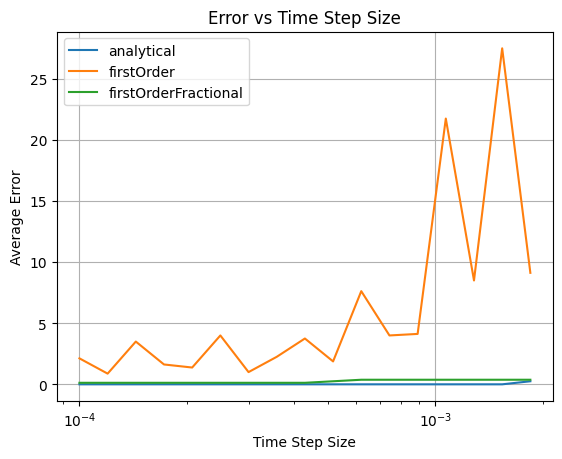

In [6]:
import math
import matplotlib.pyplot as plt
import numpy as np

class FirstOrderLIF: # First Order Leaky Integrate and Fire
    def __init__(self, tau_rc=0.2, tau_ref=0.002, v_init=0, v_th=1): # Default values for tau_rc and v_init
        self.tau_rc  = tau_rc  # Set instance variables
        self.tau_ref = tau_ref
        self.v       = v_init
        self.v_th    = v_th

        self.output = 0
        self.refractory_time = 0
        

    def step(self, I, t_step): # Advance one time step (input I and time step size t_step)
        self.refractory_time -= t_step # Subtract the amount of time that passed from our refractory time

        if self.refractory_time < 0: # If we aren't in our refractory period, update the voltage
            self.v = self.v * (1 - t_step / self.tau_rc) + I * t_step / self.tau_rc

        if self.v >= self.v_th:      # Voltage is above the threshold
            self.refractory_time = self.tau_ref # Start refractory countdown
            self.output = 1 / t_step            # Fire
            self.v = 0                          # Reset potential
        else:
            self.output = 0          # Don't fire

        return self.output

class FirstOrderLIF2: # First Order Leaky Integrate and Fire
    def __init__(self, tau_rc=0.2, tau_ref=0.002, v_init=0, v_th=1): # Default values for tau_rc and v_init
        self.tau_rc  = tau_rc  # Set instance variables
        self.tau_ref = tau_ref
        self.v       = v_init
        self.v_th    = v_th

        self.output = 0
        self.refractory_time = 0
        

    def step(self, I, t_step): # Advance one time step (input I and time step size t_step)
        self.refractory_time -= t_step # Subtract the amount of time that passed from our refractory time

        # vvv CHANGED vvv
        delta_t = t_step - self.refractory_time # How much time passed where we can actually accept input?
        if delta_t < 0:      delta_t =  0       # Make sure it's not negative
        if delta_t > t_step: delta_t = t_step   # Make sure it's not greater than our time step
        # ^^^ CHANGED ^^^

        self.v = self.v * (1 - delta_t / self.tau_rc) + I * delta_t / self.tau_rc # CHANGED: Note that we use delta_t rather than t_step

        if self.v >= self.v_th:      # Voltage is above the threshold
            spike_time = (self.tau_rc * (self.v_th - self.v) + t_step * (I - self.v_th)) / (I - self.v)
            self.refractory_time = self.tau_ref + spike_time # Start refractory countdown
        
            self.output = 1 / t_step                         # Fire
            self.v = 0                                       # Reset potential
        else:
            self.output = 0          # Don't fire

        return self.output

NUM_SECONDS = 2
TIME_STEP_SIZES = []

currSize = 0.0001
while currSize < 0.002:
    TIME_STEP_SIZES.append(currSize)
    currSize *= 1.2

def getSpikeCount(neuron, I, numSeconds, timeStepSize):
    numSteps = int(numSeconds / timeStepSize)
    count = 0
    for i in range(numSteps):
        output = neuron.step(I(i * timeStepSize), timeStepSize)
        if output > 0:
            count += 1
    return count

neurons = {
    'analytical': lambda: AnalyticalLIF(),
    'firstOrder': lambda: FirstOrderLIF(),
    'firstOrderFractional': lambda: FirstOrderLIF2()
}

avgErrors = { k: [] for k in neurons.keys() }
errors = { k: {} for k in neurons.keys() }

for timeStepSize in TIME_STEP_SIZES:
    for k in errors:
        errors[k][timeStepSize] = []

for i in [1.2, 2, 4, 8, 16, 32, 64, 128]:
    I = lambda t: i
    groundTruthCount = getSpikeCount(AnalyticalLIF(), I, NUM_SECONDS, 1e-6)

    for neuronType in neurons:
        for timeStepSize in TIME_STEP_SIZES:
            neuron = neurons[neuronType]()
            err = abs(groundTruthCount - getSpikeCount(neuron, I, NUM_SECONDS, timeStepSize))
            errors[neuronType][timeStepSize].append(err)
            
        
for neuronType in neurons:
    for timeStepSize in TIME_STEP_SIZES:
        avgErrors[neuronType].append(np.mean(errors[neuronType][timeStepSize]))

# Plotting the error vs time step size
plt.figure()

for neuronType in neurons:
    plt.plot(TIME_STEP_SIZES, avgErrors[neuronType], label=neuronType)

plt.xscale('log')
plt.xlabel('Time Step Size')
plt.ylabel('Average Error')
plt.title('Error vs Time Step Size')
plt.legend()
plt.grid(True)
plt.show()

In the graph below, a *lower* error rate is better.

As we can see, our analytical solution (blue line) performs better than our original solution (orange line). This tells us that with the analytical model of LIFs, we might be able to use slightly larger time steps while maintaining accuracy.

## Improving Accuracy for Synapses

We can also improve the accuracy of the synapse model we've been using, similar to how we did for LIFs.

:::{dropdown} Analytical Model for Synapses

## (Optional) Analytical Model for Synapses
As was the case for LIFs, our update function $g[t+1] = g[t] (1 - \frac{T_{step}}{\tau_s}) + \frac{T_{step}}{\tau_s}\delta_s[t]$ is an *estimate*. We can get more precise in our estimate if we do the same analytical modeling that we did for our LIF neurons. Rather than repeating the analysis here, we will write our solution as:

$$g[t + 1] = \delta_s[t] + e^{-\frac{T_{step}}{\tau_{s}}}(g[t] - \delta_s[t])$$

and we could update our `step()` function accordingly:

```python
self.output = I + math.exp(-t_step/tau_s) * (self.output - I)
```
```{dropdown} (Double Optional) Another way to think about this using State Space Modeling
### (Optional * 2) State Space Modeling

We were able to compute our synapse's response analytically but this might be more difficult with more complex synapse models. For those, it might be easuer to model it using a state-space representation.

#### Linear Time Invariance (LTI)

If we had a more complex synapse model, analysis does not become too much more difficult as long as we assume our synapse model $g(t)$ is a [linear time-invariant (LTI) system](https://en.wikipedia.org/wiki/Linear_time-invariant_system). This means that:

1. **Time invariance**: If we shift our spike time by any amount of time $T$, the synapse potential would be exactly the same but also shifted by $T$. Mathematically, this means that if our input signal is $x(t)$ then if $x(t)$ produces response $g(t)$ then $x(t + T)$ produces response $g(t + T)$.
2. **Linearity**: Our response scales linearly with the input. What this means is that if we have multiple inputs $x_1(t)$ and $x_2(t)$ with respective responses $g_1(t)$ and $g_2(t)$, then if we add the inputs $x(t) = x_1(t) + x_2(t)$ then the resulting response is the sum of the outputs: $g(t) = g_1(t) + g_2(t)$.

With LTI systems, we can compute the output of any arbitrary input signal *just by knowing its "impulse response" function* $h(t)$. The **impulse response** function $h(t)$ represents the potential energy over time if our neuron fired *exactly once* at $t=0$. It should be $0$ for $t <0$ (if it hasn't fired, there is no energy) and can be any shape for $t \ge 0$. We call $h(t)$ our **post-synaptic potential** function.

In our case, we are using:

$$
h(t) =
\begin{cases}
  0, & \text{if } t < 0\\
  \frac{1}{\tau_s}e^{-\frac{t}{\tau_{s}}}, & \text{if } t \geq 0
\end{cases}
$$

With our impulse response $h(t)$ and any input signal $u(t)$ we can compute our synapse's output (what we called $g(t)$) with a [**convolution**](https://en.wikipedia.org/wiki/Convolution), represented as $u(t) \ast h(t)$:

$$g(t) = u(t) \ast h(t) = (u \ast h)(t) = \int_{-\infty}^{\infty} u(\tau)h(t - \tau),d\tau$$


#### State Space Computation

In systems analysis, it is common to analyze system dynamics by translating it to a "state space" representation that summarizes the dynamics and output given an input:

$$x'(t) = Ax(t) + Bu(t)$$
$$g(t) = Cx(t) + Du(t)$$

Where $x(t)$ represents the state of the system, $x'(t)$ represents the rate of change of $x(t)$, $u(t)$ represents the input, and $g(t)$ represents the output.

Since we are assuming that we are working in an LTI, the output of our neuron, $y(t)$ is the input, $u(t)$ convolved with the impulse response function $h(t)$:

$$g(t) = (u \ast h)(t)$$

We can use the [Laplace transform](https://en.wikipedia.org/wiki/Laplace_transform) to help transform our functions into the frequency domain and simply do multiplication:

$$G(s) = U(s)H(s)$$

We can first take the Laplace transform of $h(t)$ to transfer it into frequency space:

$$ \mathscr{L}\{h(t)\} = H(s) = \frac{G(s)}{U(s)} = \int_{t=0}^{\infty}h(t)e^{-st}dt $$

So plugging in $h(t) = \frac{1}{\tau_s}e^{-\frac{t}{\tau_s}}$, we get 

$$ H(s) = \frac{G(s)}{U(s)} = \int_{t=0}^{\infty}\frac{1}{\tau_s}e^{-\frac{t}{\tau_s}}e^{-st}dt $$

If we solve this, we get:

$$ H(s) = \frac{1}{s\tau_s + 1} = \frac{G(s)}{U(s)} $$

In our case, there is effectively no difference between $x(t)$ and $g(t)$, as our "state"---the potential---is also the output. So let's set $x(t) = g(t)$. Recalling our state space equations, we are saying that $C = 1$ and $D = 0$.

$$x'(t) = Ax(t) + Bu(t)$$
$$g(t) = Cx(t) + Du(t) = x(t)$$

then, substituting $X(s)$ for $G(s)$ in the above equation, we get:

$$ H(s) = \frac{1}{s\tau_s + 1} = \frac{X(s)}{U(s)} $$
$$ U(s) = s\tau_sX(s) + X(s) $$
$$ sX(s) = -\frac{1}{\tau_s}X(s) + \frac{1}{\tau_s}U(s) $$

Taking the inverse Laplace transform ($\mathscr{L}^{-1}$), we get:

$$ \mathscr{L}^{-1}\{sX(s)\} = \mathscr{L}^{-1}\{-\frac{1}{\tau_s}X(s) + \frac{1}{\tau_s}U(s)\} $$
$$ x'(t) = -\frac{1}{\tau_s}x(t) + \frac{1}{\tau_s}u(t) $$

So in other words, we have $A = -\frac{1}{\tau_s}$, $B = \frac{1}{\tau_s}$, $C = 1$, $D = 0$

#### Transforming State Space to Discrete Time

However, our state space representation is not yet complete because it is for **continuous time** whereas we are working in discrete time. So we need to [discretize our state space model](https://en.wikipedia.org/wiki/Discretization#Discretization_of_linear_state_space_models). In other words, we need to find coefficients $A_d$, $B_d$, $C_d$, $D_d$:

$$ x[t+1] = A_dx[t] + B_du[t] $$
$$ g[t] = C_dx[t] + D_du[t] $$

We can find these based on our prior coefficients $A = -\frac{1}{\tau_s}$, $B = \frac{1}{\tau_s}$, $C = 1$, $D = 0$. Because the second equation is just extracting the relevant output ($y$) from our state ($x$). So $C_d = C = 1$ and $D_d = D = 0$.

Now, we need to find $A_d$ and $B_d$. We will assume that each time step has size $T_{step}$ and that within each time step, the input $u$ is constant.

We can use [a process for transforming the values for A, B, C, and D to discrete space](https://en.wikipedia.org/wiki/Discretization#Discretization_of_linear_state_space_models) which would result in:

$$A_d = e^{AT_{step}}$$
$$A_d = e^{-\frac{T_{step}}{\tau_s}}$$
and
$$\newline{}B_d = A^{-1}(A_d - I)B$$
$$B_d = -\tau_s(e^{-\frac{T_{step}}{\tau_s}}-1)\frac{1}{\tau_s}$$
$$B_d = 1 - e^{-\frac{T_{step}}{\tau_s}}$$

Noting that $g[t] = x[t]$ and re-naming our input to be consistent $u[t] = \delta_s[t]$ This gives us:

$$ g[t+1] = A_dg[t] + B_d\delta_s[t] $$
$$ g[t+1] = g[t]e^{-\frac{T_{step}}{\tau_s}} + (1 - e^{-\frac{T_{step}}{\tau_s}})\delta_s[t] $$
$$ g[t+1] = \delta_s[t] + e^{-\frac{T_{step}}{\tau_s}}(g[t] - \delta_s[t]) $$

And we can see that our space state representation yields the same result as our analytical solution.
```

Although our analytical solution is more accurate, there is a computational cost to performing `Math.exp` instead of simple addition and multiplication...however, we can actually address this by pre-computing the value $e^{-\frac{T_{step}}{\tau_{s}}}$, assigning it to a variable (let's say `a`) and assigning:

```python
a = math.exp(-t_step/tau_s)
self.output = I + a * (self.output - I)
```
:::

In [3]:
import numpy as np

class Synapse:
    def __init__(self, tau_s=0.05):
        self.tau_s = tau_s
        self.output = 0
    
    def step(self, I, t_step):
        self.output = I + np.exp(-t_step / self.tau_s) * (self.output - I)
        return self.output

We see that if we increase our time step size ($T_{step}$), our analytical solution stays more faithful to the accurate solution (the dashed line below):

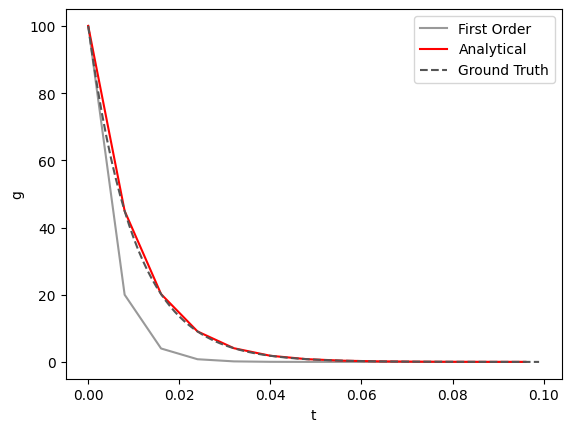

In [7]:
import numpy as np
import matplotlib.pyplot as plt

tstep = 0.008


minT, maxT = 0, 0.1
tau_s = 1e-2
gTruthTStep = 1e-3

gTruthData = []

gTruthG = 0

for t in np.arange(minT, maxT, gTruthTStep):
    if abs(t) < gTruthTStep/2:
        gTruthG = 100
    else:
        gTruthG = np.exp(-gTruthTStep / tau_s) * gTruthG
    gTruthData.append((t, gTruthG))

data = []

firstOrderG = 0
analyticalG = 0

for t in np.arange(minT, maxT, tstep):
    if abs(t) < tstep/2:
        analyticalG = firstOrderG = 100
    else:
        analyticalG = np.exp(-tstep / tau_s) * analyticalG
        firstOrderG = firstOrderG * (1 - tstep / tau_s)
    data.append((t, firstOrderG, analyticalG))

data = np.array(data)
gTruthData = np.array(gTruthData)

plt.figure()

plt.plot(data[:, 0], data[:, 1], label='First Order', color='#999')
plt.plot(data[:, 0], data[:, 2], label='Analytical', color='red')
plt.plot(gTruthData[:, 0], gTruthData[:, 1], label='Ground Truth', color='#555', linestyle='--')

plt.xlabel('t')
plt.ylabel('g')
plt.legend()
plt.show()

## Resources

- The Youtube channel 3Blue1Brown has a useful [video describing convolutions](https://youtu.be/KuXjwB4LzSA)
- The same channel has a useful [introduction to the Fourier Transform](https://youtu.be/spUNpyF58BY) (which is a good starting point for understanding the Laplace transform)
- The use of state space modeling was inspired by [Nengo's synapse implementation](https://github.com/nengo/nengo/blob/dc0419fbe571374d0a55a7f67309dfcb254a2e88/nengo/synapses.py), which uses state space modeling for synapses

## References

- Parts of the LIF implementation were adapted from [Nengo's LIF implementation](https://github.com/nengo/nengo/blob/dc0419fbe571374d0a55a7f67309dfcb254a2e88/nengo/neurons.py#L612-L685)